<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Data Augmentation

One of the most important steps when building a model for Computer Vision is data augmentation.
Using more training data can make the model generalize better, but it is very expensive to collect data.
Instead, augmenting the training data with minor alterations has been proven to work well.

In this notebook, we explore why the data augmentation works and how it affects the result of different image classification problems, *[MNIST](http://yann.lecun.com/exdb/mnist/)* and *Fridge Objects*<sup>*</sup>. To make this task simple, we only test three basic transformation functions in [fastai](https://docs.fast.ai/vision.transform.html)--`get_transforms`, `zoom_crop` and `rand_resize_crop`--which have been working pretty well in a wide range of tasks with the default parameters.

<sub>* To learn more about Fridge Objects dataset and performance, check out [training introduction notebook](01_training_introduction.ipynb)</sub>

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
from tempfile import TemporaryDirectory

import fastai
from fastai.vision import *
from fastai.metrics import accuracy
import pandas as pd
import torch 

from utils_ic.constants import IMAGENET_IM_SIZE as IMAGE_SIZE
from utils_ic.datasets import unzip_url, Urls
from utils_ic.fastai_utils import TrainMetricsRecorder
from utils_ic.gpu_utils import which_processor
from utils_ic.plot_utils import plot_pr_roc_curves, ResultsWidget

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla K80
Available / Total memory = 11430 / 11441 (MiB)


This shows your machine's GPUs (if has any) and which computing device fastai/torch is using. The output cells here show the run results on [Azure DSVM](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/) Standard NC6.

In [3]:
# Parameters
SEED          = 42  # Random seed
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50
DATA_PATH     = 'data' # To cache the dataset for later use, set DATA_PATH

In [4]:
tmpdir = TemporaryDirectory()
if DATA_PATH is None:
    DATA_PATH = tmpdir.name
    
datasets = {}

## 1. Two different problems: Handwritten digit vs. Fridge object

TODO: Some texts here about how these two are different and why we picked these examples.


#### MNIST

In [5]:
# MNIST TINY
mnist_path = untar_data(
    URLs.MNIST_TINY,
    os.path.join(DATA_PATH, 'mnist.tgz'),
    DATA_PATH
)
mnist_path.ls()

/data/anaconda/envs/cvbp/lib/python3.6/site-packages/fastai/datasets.py:159: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


[PosixPath('data/mnist_tiny/models'),
 PosixPath('data/mnist_tiny/labels.csv'),
 PosixPath('data/mnist_tiny/test'),
 PosixPath('data/mnist_tiny/valid'),
 PosixPath('data/mnist_tiny/train')]

MNIST
Num train = 709, num valid = 699
Classes = ['3', '7']


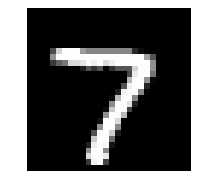

In [6]:
datasets['mnist'] = (
    ImageList.from_folder(mnist_path)
    .split_by_folder()
    .label_from_folder()
)

print("MNIST")
print(f"Num train = {len(datasets['mnist'].train)}, num valid = {len(datasets['mnist'].valid)}")
print(f"Classes = {datasets['mnist'].classes}")

datasets['mnist'].train.x[0].show()

#### Fridge Objects

*Fridge object* dataset consists of 134 images of can, carton, milk bottle and water bottle photos taken with different backgrounds.

In [7]:
fridge_path = unzip_url(Urls.fridge_objects_path, DATA_PATH, exist_ok=True)
fridge_path.ls()

[PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/models'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/water_bottle'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/carton'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/can'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/milk_bottle')]

Fridge object
Num train = 67, num valid = 67
Classes = ['can', 'carton', 'milk_bottle', 'water_bottle']


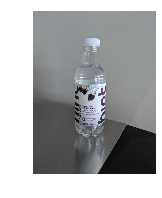

In [8]:
datasets['fridge'] = (
    ImageList.from_folder(fridge_path)
    .split_by_rand_pct(valid_pct=0.5, seed=SEED) 
    .label_from_folder()
)

print("Fridge object")
print(f"Num train = {len(datasets['fridge'].train)}, num valid = {len(datasets['fridge'].valid)}")
print(f"Classes = {datasets['fridge'].classes}")

datasets['fridge'].train.x[0].show()

## 2. Image transformation

We test following transformations:
1. No transforms
1. `get_transforms` with horizontal and vertical flips
1. `get_transforms` with horizontal flip
1. `get_transforms` without flip
1. `zoom_crop`
1. `rand_resize_crop`

Note, each transform functions returns a tuple of two list of transforms: one for the training set and one for the validation set (the second list of transforms is limited to resizing the pictures). For the full list of transformation `fastai` supports, see [its API documents](https://docs.fast.ai/vision.transform.html).

In [9]:
# We keep all the other parameters as defaults.
tfms_options = {
    'no_tfms': None,
    'flip': get_transforms(do_flip=True, flip_vert=True),
    'flip_no_vert': get_transforms(do_flip=True, flip_vert=False),
    'no_flip': get_transforms(do_flip=False),
    'zoom_crop': zoom_crop(scale=(0.75,2), do_rand=True),
    'rand_resize_crop': rand_resize_crop(224)
}

#### Examples of not-very-useful (or even bad) transformations vs. good transformations

Again, this will be pretty much dependent on the problem we would like to solve.


<img src="figs/augmentation_m_w.jpg" alt="m and w" width="200"/>

<center><i>You probablly do not want to vertical-flip letters</i></center>


In [10]:
def plot_ex(im, tfms_ops):
    _, axes = plt.subplots(1, len(tfms_ops), figsize=(4*len(tfms_ops), 4))
    for i, (name, tfms) in enumerate(tfms_ops.items()):
        if tfms is None:
            im.show(ax=axes[i], title=name)
        else:
            im.apply_tfms(tfms[0]).show(ax=axes[i], title=name)  # tfms[0]: tfms for the training set

def random_seed(s):
    np.random.seed(s)
    torch.manual_seed(s)
    random.seed(s)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(s)
        torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

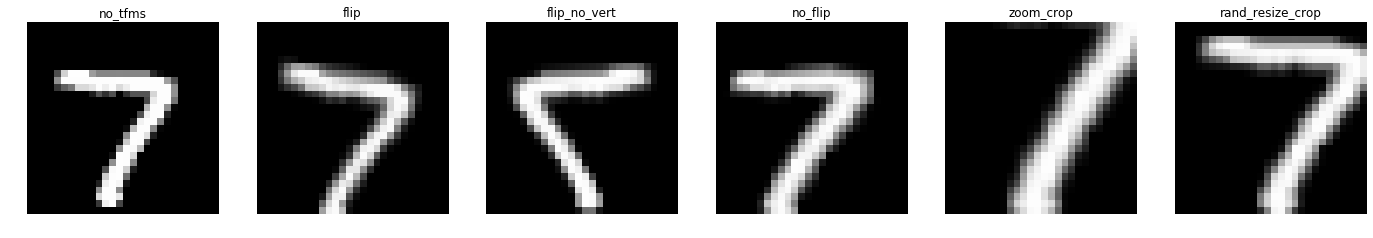

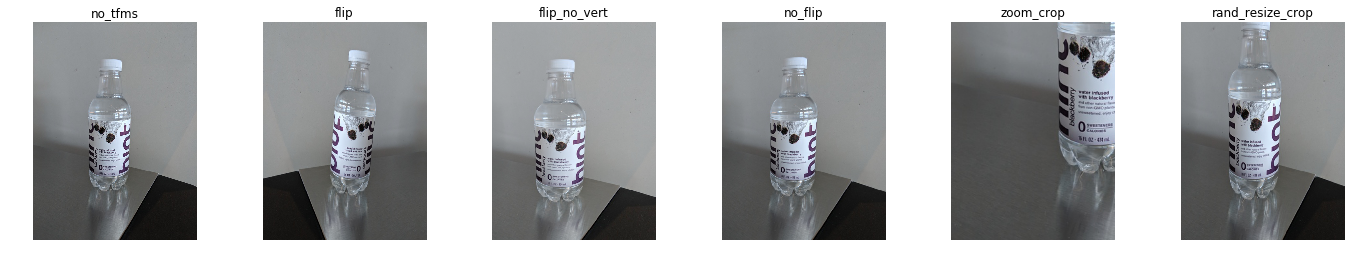

In [11]:
random_seed(SEED)
plot_ex(datasets['mnist'].train.x[0], tfms_options)
plot_ex(datasets['fridge'].train.x[0], tfms_options)

## 3. Training and evaluation 

In [12]:
df_results = pd.DataFrame(columns=['data', 'transform', 'train_acc', 'valid_acc'])
interps = {}  # Cache ClassificationInterpretation objects

for dn, d in datasets.items():
    itp = {}
    for tn, tfms in tfms_options.items():
        print(f"{dn} {tn}")
        data = d.transform(tfms, size=IMAGE_SIZE).databunch(bs=BATCH_SIZE, num_workers=1).normalize(imagenet_stats)
        
        # Set seed to reproduce the results, 
        random_seed(SEED)  
        learn = cnn_learner(
            data,
            ARCHITECTURE,
            metrics=[accuracy],
            callback_fns=[TrainMetricsRecorder]
        )
        learn.fit_one_cycle(5)

        train_metrics = learn.train_metrics_recorder.last_train_metrics()
        valid_metrics = learn.train_metrics_recorder.last_valid_metrics()
        row = [dn, tn, f"{100*float(train_metrics[0]):3.2f}", f"{100*float(valid_metrics[0]):3.2f}"]

        df_results.loc[df_results.shape[0] + 1] = row
        itp[tn] = ClassificationInterpretation.from_learner(learn)
    
    interps[dn] = itp


In [13]:
df_results

,data,transform,train_acc,valid_acc
1,mnist,no_tfms,99.01,100.00
2,mnist,flip,94.74,99.28
3,mnist,flip_no_vert,97.44,99.71
4,mnist,no_flip,97.59,99.57
5,mnist,zoom_crop,92.33,99.14
6,mnist,rand_resize_crop,97.16,98.86
7,fridge,no_tfms,98.44,92.54
8,fridge,flip,95.31,88.06
9,fridge,flip_no_vert,96.88,92.54
10,fridge,no_flip,96.88,97.01


TODO results analysis

- Show examples of top loss and describe why a specific transforms did not work


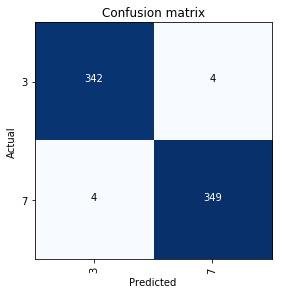

In [14]:
dn = 'mnist'
tn = 'rand_resize_crop'

interps[dn][tn].plot_confusion_matrix()

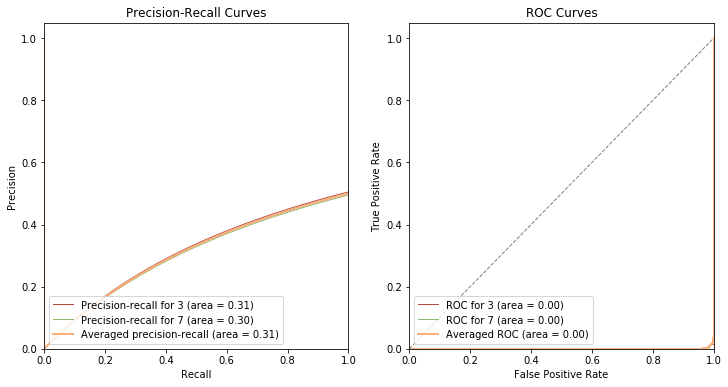

In [15]:
plot_pr_roc_curves(to_np(interps[dn][tn].y_true), to_np(interps[dn][tn].probs), datasets[dn].classes)

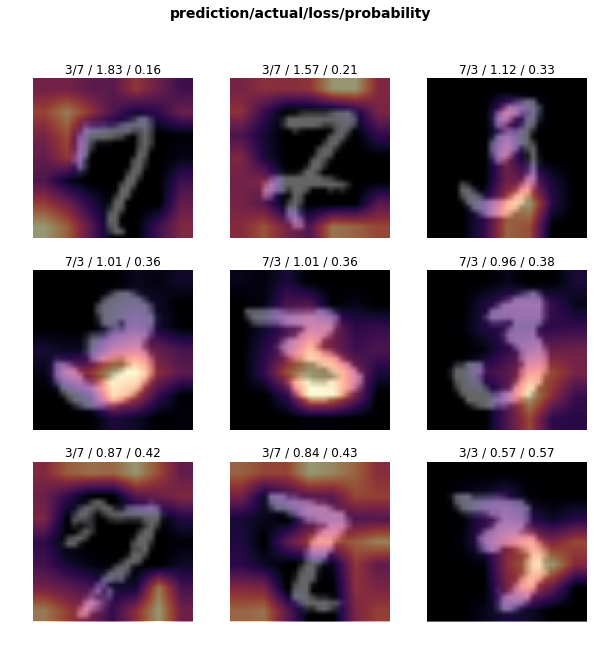

In [19]:
interps[dn][tn].plot_top_losses(9, figsize=(10,10))

## 3. Concluding remarks

TODO Recap

In [ ]:
# Cleanup
tmpdir.cleanup()